In [1]:
# 폰트깨짐

!pip install koreanize_matplotlib -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/BigContest

/content/drive/MyDrive/BigContest


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

# 1. 데이터 로드
# Specify encoding as cp949 to handle potential encoding issues
df_info = pd.read_csv('dataset1_info.csv', encoding='cp949')
df_monthly = pd.read_csv('dataset2_monthly_usage.csv', encoding='cp949')
df_customer = pd.read_csv('dataset3_customer_info.csv', encoding='cp949')

# 2. 데이터 정제 (결측치 및 타입 변환)
# -999999.9 값을 NaN으로 변경
df_monthly.replace(-999999.9, np.nan, inplace=True)
df_customer.replace(-999999.9, np.nan, inplace=True)

# TA_YM을 datetime으로 변환
df_monthly['TA_YM'] = pd.to_datetime(df_monthly['TA_YM'], format='%Y%m')
df_customer['TA_YM'] = pd.to_datetime(df_customer['TA_YM'], format='%Y%m')

# 3. 데이터 통합
# 월별 이용 정보와 고객 정보를 먼저 합침
df_merged = pd.merge(df_monthly, df_customer, on=['ENCODED_MCT', 'TA_YM'], how='left')

# 가맹점 개요 정보와 최종 통합
df_final = pd.merge(df_merged, df_info, on='ENCODED_MCT', how='left')

print("최종 통합 데이터프레임 모양:", df_final.shape)
df_final.head()

최종 통합 데이터프레임 모양: (86590, 38)


,ENCODED_MCT,TA_YM,MCT_OPE_MS_CN,RC_M1_SAA,RC_M1_TO_UE_CT,RC_M1_UE_CUS_CN,RC_M1_AV_NP_AT,APV_CE_RAT,DLV_SAA_RAT,M1_SME_RY_SAA_RAT,...,RC_M1_SHC_WP_UE_CLN_RAT,RC_M1_SHC_FLP_UE_CLN_RAT,MCT_BSE_AR,MCT_NM,MCT_BRD_NUM,MCT_SIGUNGU_NM,HPSN_MCT_ZCD_NM,HPSN_MCT_BZN_CD_NM,ARE_D,MCT_ME_D
0,000F03E44A,2024-04-01,4_50-75%,5_75-90%,5_75-90%,5_75-90%,5_75-90%,1_상위1구간,NaN,2.6,...,12.5,75.0,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,20220225,NaN
1,000F03E44A,2023-12-01,4_50-75%,6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),6_90%초과(하위 10% 이하),NaN,NaN,0.0,...,NaN,NaN,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,서울 성동구,중식-딤섬/중식만두,뚝섬,20220225,NaN
2,002816BA73,2024-04-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),NaN,96.6,...,23.8,52.4,서울 성동구 청계천로10나길 78,자갈***********,NaN,서울 성동구,요리주점,마장동,20140507,NaN
3,002816BA73,2024-11-01,2_10-25%,3_25-50%,4_50-75%,4_50-75%,2_10-25%,6_상위6구간(하위1구간),NaN,108.0,...,11.5,76.9,서울 성동구 청계천로10나길 78,자갈***********,NaN,서울 성동구,요리주점,마장동,20140507,NaN
4,002816BA73,2024-06-01,2_10-25%,4_50-75%,4_50-75%,4_50-75%,2_10-25%,1_상위1구간,NaN,74.2,...,17.4,69.6,서울 성동구 청계천로10나길 78,자갈***********,NaN,서울 성동구,요리주점,마장동,20140507,NaN


In [5]:
# ----------------------------------------
# 3. 피처 엔지니어링 (Feature Engineering)
# ----------------------------------------
print("\n--- 피처 엔지니어링 시작 ---")

# 3-1. 구간형 데이터를 숫자형으로 변환하는 함수
# 예: '4_50-75%' -> 4
def get_rank_from_category(data):
    if pd.isna(data):
        return np.nan
    try:
        # '_'를 기준으로 분리하여 첫 번째 요소(순위)를 정수형으로 반환
        return int(str(data).split('_')[0])
    except:
        return np.nan

# 변환할 컬럼 리스트
rank_cols = ['MCT_OPE_MS_CN', 'RC_M1_SAA', 'RC_M1_TO_UE_CT', 'RC_M1_UE_CUS_CN', 'RC_M1_AV_NP_AT', 'APV_CE_RAT']
for col in rank_cols:
    df_final[col + '_RANK'] = df_final[col].apply(get_rank_from_category)

print("구간형 데이터 -> 숫자형 순위 데이터 변환 완료.")

# 3-2. 날짜 데이터 활용
df_final['ARE_D'] = pd.to_datetime(df_final['ARE_D'], format='%Y%m%d', errors='coerce')
df_final['MCT_ME_D'] = pd.to_datetime(df_final['MCT_ME_D'], format='%Y%m%d', errors='coerce')

# 분석 시점(마지막 데이터 기준 월)
latest_month = df_final['TA_YM'].max()

# 총 운영 기간 (일) 계산
df_final['MCT_OPE_DAYS'] = (latest_month - df_final['ARE_D']).dt.days
print("총 운영 기간(일) 컬럼 생성 완료.")

# 3-3. 주요 고객층 컬럼 생성
# 성별/연령대 비율 컬럼만 선택
demo_cols = ['M12_MAL_1020_RAT', 'M12_MAL_30_RAT', 'M12_MAL_40_RAT', 'M12_MAL_50_RAT', 'M12_MAL_60_RAT',
             'M12_FME_1020_RAT', 'M12_FME_30_RAT', 'M12_FME_40_RAT', 'M12_FME_50_RAT', 'M12_FME_60_RAT']

# 각 행(가맹점-월)에서 가장 높은 비율을 차지하는 고객층 찾기
df_final['MAIN_CUSTOMER'] = df_final[demo_cols].idxmax(axis=1)
# 컬럼명에서 RAT 제거 등 보기 좋게 정리
df_final['MAIN_CUSTOMER'] = df_final['MAIN_CUSTOMER'].str.replace('M12_', '').str.replace('_RAT', '').str.replace('MAL', '남성').str.replace('FME', '여성')
print("주요 고객층 컬럼 생성 완료.")
print("--- 피처 엔지니어링 완료 ---\n")


--- 피처 엔지니어링 시작 ---
구간형 데이터 -> 숫자형 순위 데이터 변환 완료.
총 운영 기간(일) 컬럼 생성 완료.
주요 고객층 컬럼 생성 완료.
--- 피처 엔지니어링 완료 ---



/tmp/ipython-input-92366900.py:41: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_final['MAIN_CUSTOMER'] = df_final[demo_cols].idxmax(axis=1)


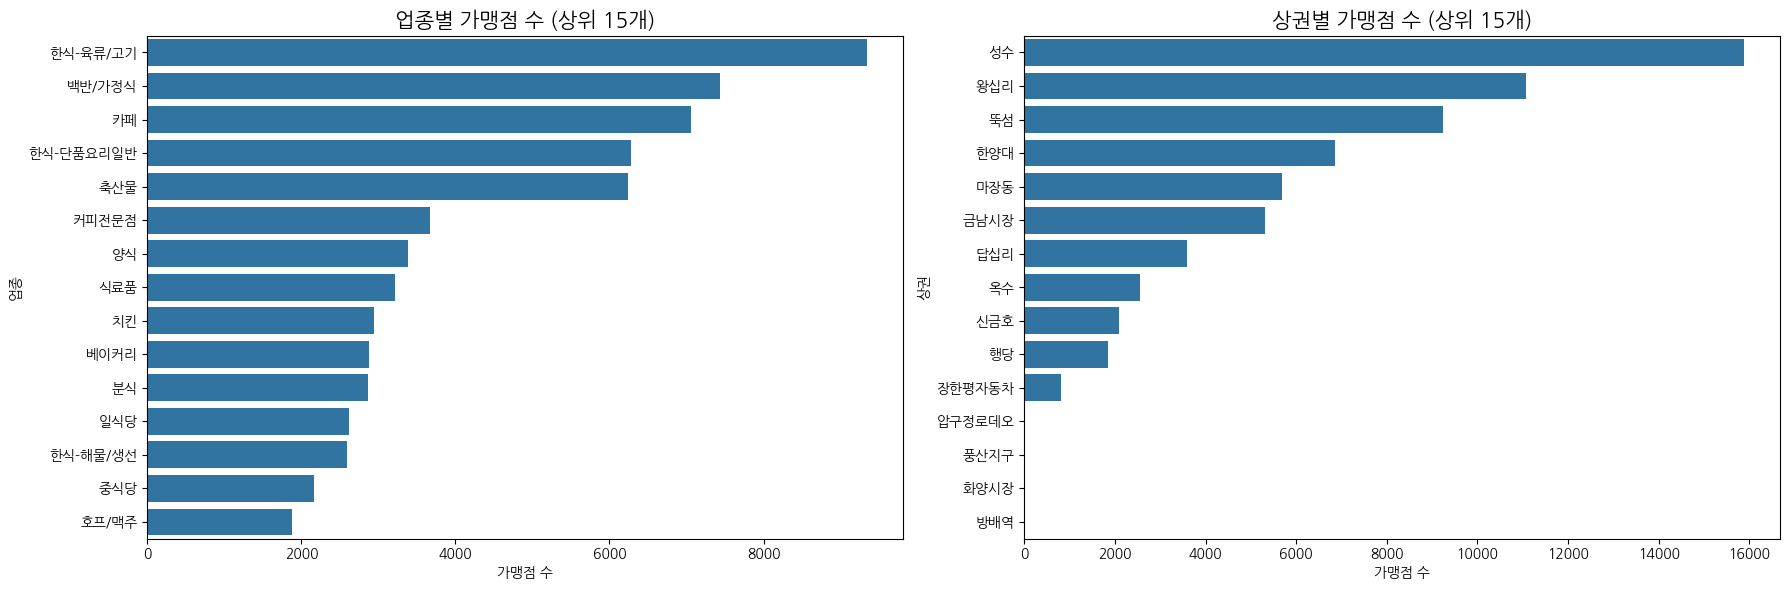

In [6]:
# EDA, 시각화

# 1. 전반적인 가맹점 분포 확인
plt.figure(figsize=(18, 6))

# 업종별 가맹점 수
plt.subplot(1, 2, 1)
sns.countplot(y='HPSN_MCT_ZCD_NM', data=df_final, order=df_final['HPSN_MCT_ZCD_NM'].value_counts().index[:15])
plt.title('업종별 가맹점 수 (상위 15개)', fontsize=15)
plt.xlabel('가맹점 수')
plt.ylabel('업종')

# 상권별 가맹점 수
plt.subplot(1, 2, 2)
sns.countplot(y='HPSN_MCT_BZN_CD_NM', data=df_final, order=df_final['HPSN_MCT_BZN_CD_NM'].value_counts().index[:15])
plt.title('상권별 가맹점 수 (상위 15개)', fontsize=15)
plt.xlabel('가맹점 수')
plt.ylabel('상권')

plt.tight_layout()
plt.show()

In [7]:
# 업종: 고깃집, 백반집, 카페 순으로 경쟁이 빡셈
# 성수, 왕십리, 뚝섬 이쪽 핫플이라 경쟁 빡셈 (물론 그만큼 유동인구도 많겠지만)


# => 이렇게 경쟁이 심한 업종이나 위치에 있는 가게에게, 아직 공략되지 않은 고객층(ex. 40대 여성), 시간대 (ex. 심야 영업), 서비스 (혼밥 맞춤 메뉴)를 데이터 기반으로 찾아내서
# "사장님! 이 시장은 아직 할 만 해요! 이런 걸 추가하면 좀 비빌 수 있어요!" 이런 느낌으로 제안하는 에이전트

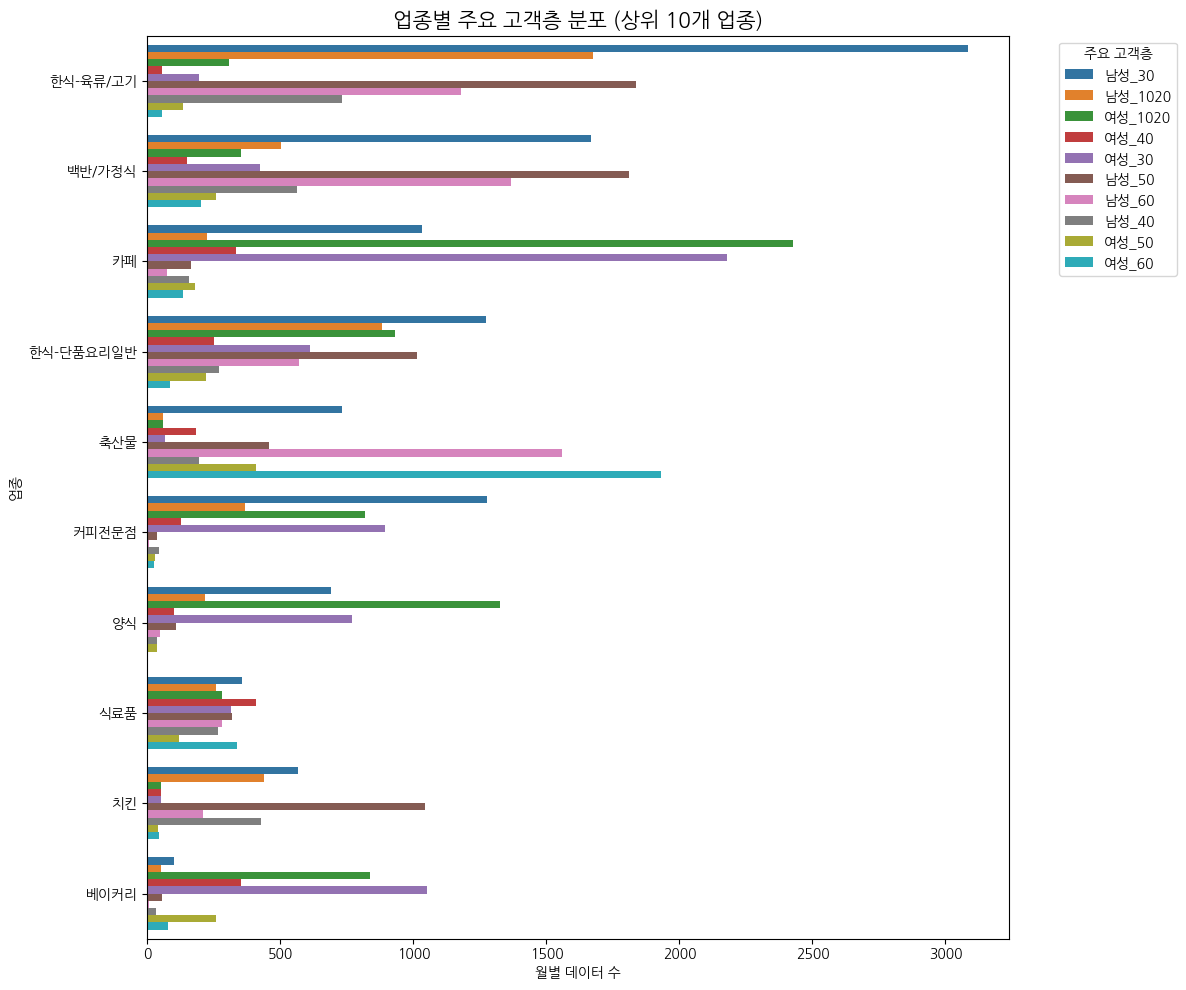

In [8]:
# 2. 업종별 주요 고객층 분석
plt.figure(figsize=(12, 10))
# 업종 상위 10개만 필터링
top10_industry = df_final['HPSN_MCT_ZCD_NM'].value_counts().index[:10]
df_top10_industry = df_final[df_final['HPSN_MCT_ZCD_NM'].isin(top10_industry)]

sns.countplot(y='HPSN_MCT_ZCD_NM', hue='MAIN_CUSTOMER', data=df_top10_industry,
              order=top10_industry, dodge=True)
plt.title('업종별 주요 고객층 분포 (상위 10개 업종)', fontsize=15)
plt.xlabel('월별 데이터 수')
plt.ylabel('업종')
plt.legend(title='주요 고객층', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
# 수요와 공급 ..

# 고깃집: 30대 남성 압도적
# 백반/가정식: 30, 50, 60대 남성 압도적
# 카페: 102030 여성 압도적
# 한식-단품요리일반: 30대 남성이 제일 높고 // 50대 남성>1020여성>1020남성 순서로 비등비등
# 축산물: 60대 여성>60대 남성 압도적
# 커피전문점: 30대 남성 압도적 (왜지?) / 그다음은 30대 여성>1020여성
# 양식: 1020여성>>30여성>30남성
# 식료품: 40여성>30남성>60여성 인데 거의 다 비등비등함
# 치킨: 50대 남성 압도적 (아빠가 치킨사와서 그런가?) / 30남성>1020남성>40남성
# 베이커리: 30여성>1020여성 압도적


# 다른 가게(평균)와 우리 가게를 비교
# ex. 우리 카페는 다른 카페와 다르게 40대 남성 손님이 많네? 이분들을 단골로 만들 '남성 취향 메뉴? 디저트?'를 개발하거나 관련 SNS 홍보 문구를 작성해 드릴까요?
# 이런 느낌으로, 우리 가게만의 강점을 살리거나 약점을 보완하는 맞춤형 제안을 생성하는 AI 에이전트 (LLM 활용을 잘 할 수 있는 주제)


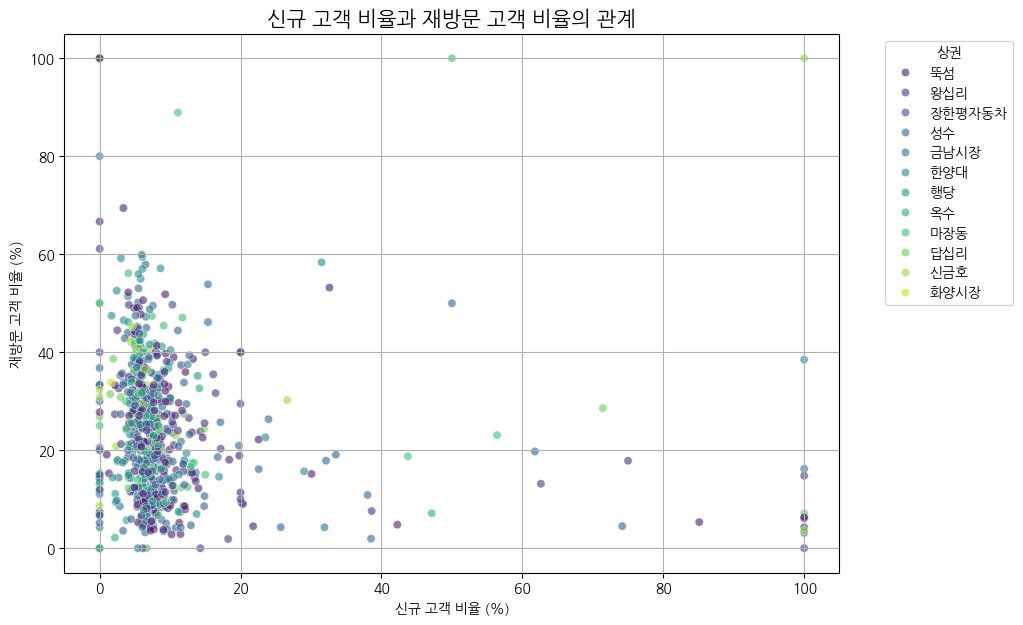

In [10]:
# 3. 성과 지표 분석: 재방문율 vs 신규고객 비율
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_final.sample(1000), x='MCT_UE_CLN_NEW_RAT', y='MCT_UE_CLN_REU_RAT',
                hue='HPSN_MCT_BZN_CD_NM', palette='viridis', alpha=0.6)
plt.title('신규 고객 비율과 재방문 고객 비율의 관계', fontsize=15)
plt.xlabel('신규 고객 비율 (%)')
plt.ylabel('재방문 고객 비율 (%)')
plt.legend(title='상권', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [11]:
# 1. 소수의 신규 고객 (0~20), 재방문 고객 비율 (0~60)
  # 기존 고객을 얼마나 잘 단골로 만드느냐!!가 중요
# 2. 이상치
  # x축 오른쪽 끝: 엥? 신규 고객 100%인데 재방문 고객 비율도 20%인 가게가 있을 수 있나?
  # 재방문 고객 비율이 20%면 신규 고객 비율은 80%여야 하는 거 아닌가?
  # 어떻게 산출된 컬럼인지 확인해봐야할 것 같음.

#

In [12]:
###### 가게의 생애주기에 맞춰서 조언해주는 Agent #####

# 신규 오픈기: 신규 고객 비율 80% 이상
# 첫인상이 중요해요!
# 마케팅: 첫 방문 고객에게, 재방문 시 사용가능한 파격적인 쿠폰 제공. 첫 단골 확보에 집중하세요.
# 만족한 고객에게 SNS 리뷰를 유도할 수 있는 서비스를 제공해서 온라인 입소문을 만드세요. (LLM으로 리뷰 요청 문구 생성하기)

# 또는 신규 비율은 높은데 재방문율이 낮으면? (이걸 어떻게 신규 오픈이랑 그냥 새로 오기만 하는 가게랑 비교하지?)
# 마케팅으로 손님은 잘 끌어오는데, 정작 여기 온 손님들이 만족 못하는 유형
# 사장님! 광고비는 그만 쓰고, 확보된 고객 데이터로 맛, 가격, 서비스 만족도에 대한 리뷰 분석을 먼저 해야해요!
# 재방문율이 낮은 핵심 원인을 찾아 해결해요!

#######################
# 안정 성장기: 신규 고객 비율 5~20, 재방문율 40 이상
# 사장님 가게는 안정적인 단골층을 기반으로 잘 성장하고 있어요! 이제 단골 고객의 만족도를 높여 이탈을 막아봐요!
# 단골 고객 데이터를 분석해서 '가장 인기있는 메뉴? 사랑받는 메뉴?' 할인 이벤트 기획!
# 또는 단골 손님들한테만 제공되는 '시크릿 메뉴' 개발해서 특별한 경험 선물 이벤트

# 근데 단골 장사로 안정적일 수는 있어도 좀 고인물 될 수 있음. 새로운 고객이 안오면 어떡함.
# 사장님! 소중한 단골분들을 활용해서 '친구 추천 이벤트'나 '단골 인증 SNS 챌린지'로 자연스럽게 신규 고객을 유치해봐요!

###############
# 정체, 위기기: 신규 고객 비율 5 이하, 재방문율 30 이하
# 삐용삐용!! 총체적 난국!!
# 사장님! 신규 고객 유입이 줄고, 기존 단골 손님도 뜸해요! 위험 신호가 감지됐어요!
# 지금부터가 반전. 이 필요합니다!!
# 한동안 안 온 손님들에게 감성적인 메시지와 함께 할인 쿠폰을 보내보세요
# 주변 지역 (거주/직장) 고객을 타겟으로 한 '동네 주민 할인' 이벤트를 통해 새로운 단골을 만들어 보세요 (LLM으로 메시지 초안 작성)
# 가게의 존재감을 다시 알려야해요!! 주변 지역 타겟으로 SNS 광고도 하고, 파격적인 신메뉴 출시해야돼요!!


/tmp/ipython-input-997358286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delivery['IS_DELIVERY_MAJOR'] = df_delivery['DLV_SAA_RAT'] > 50


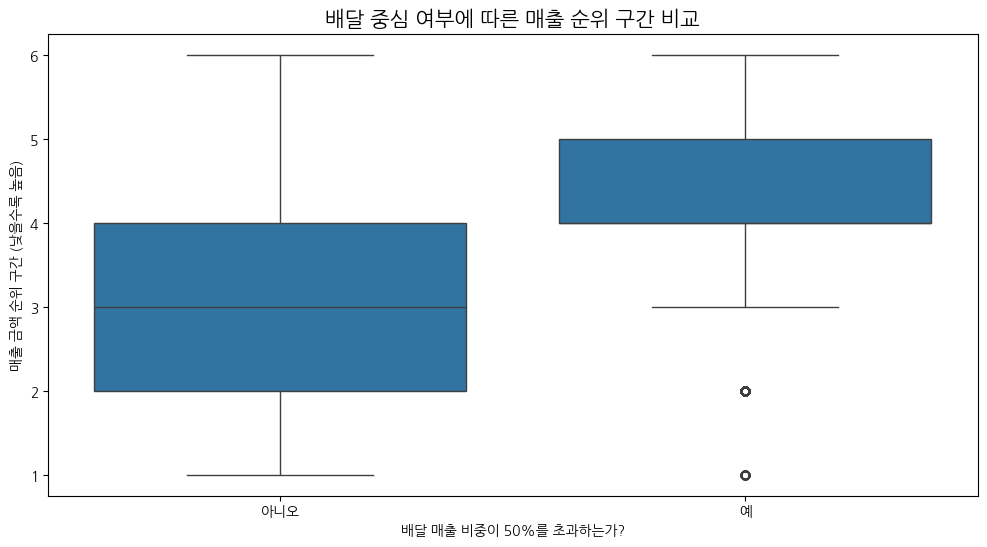

In [13]:
# 4. 배달 매출의 영향력
df_delivery = df_final.dropna(subset=['DLV_SAA_RAT'])
df_delivery['IS_DELIVERY_MAJOR'] = df_delivery['DLV_SAA_RAT'] > 50

plt.figure(figsize=(12, 6))
sns.boxplot(x='IS_DELIVERY_MAJOR', y='RC_M1_SAA_RANK', data=df_delivery)
plt.title('배달 중심 여부에 따른 매출 순위 구간 비교', fontsize=15)
plt.xlabel('배달 매출 비중이 50%를 초과하는가?')
plt.ylabel('매출 금액 순위 구간 (낮을수록 높음)')
plt.xticks([False, True], ['아니오', '예'])
plt.show()

In [14]:
# # 오. 배달 비중이 적은 가게일수록 매출이 더 높음.
# 뇌피셜: 배달하는 가게들은 샵인샵도 많고... 걍 거기서 거기임. 그리고 그닥 비싼 음식을 팔지도 않음. 가성비 음식들. 근데 배달이 아니라 가게 중심인 곳들은 단골도 많고 느낌 좋은 인테리어도 있을 테고, 음식도 신경써서 만들기 때문에 좀 더 비쌀 것 같음.

# 가게 업종, 상권 특성, 고객 데이터들을 분석해서,
# 배달이 좋을 것 같아요 vs 홀 고객의 만족도를 높이는 게 좋을 것 같아요
# 홀 고객의 만족도를 높이려면 이런 이벤트를 하는 건 어떠세요?
# 데이터에 근거해서 리포트 제공해주는 Agent

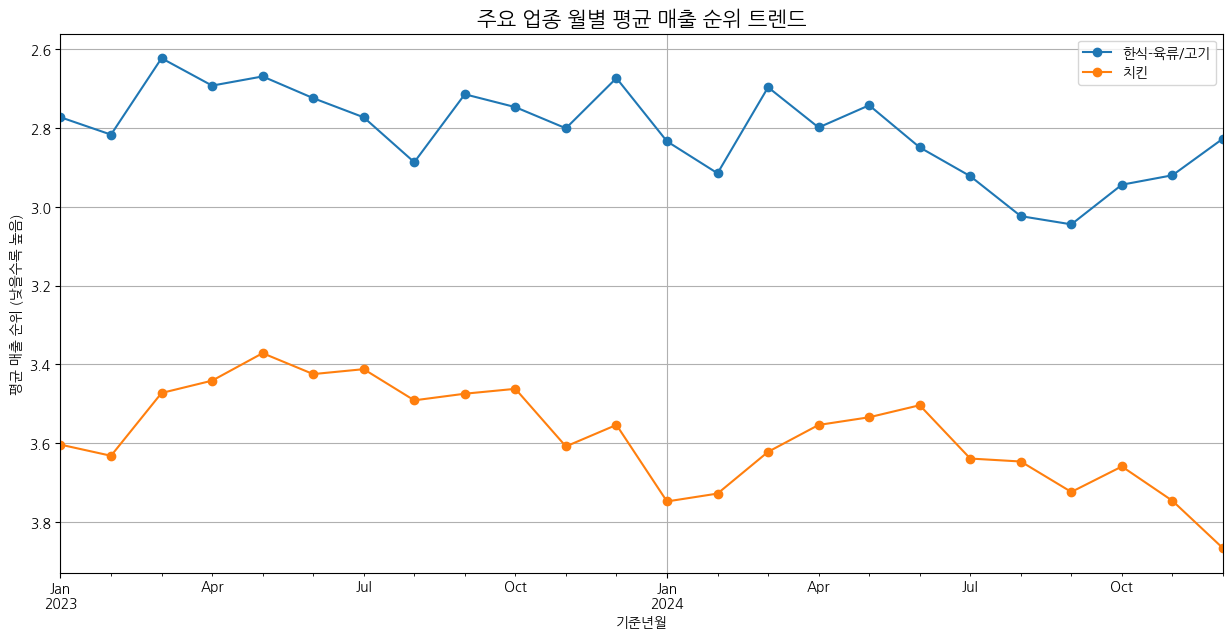

In [15]:
# 5. 시계열 분석: 특정 업종의 월별 매출 트렌드
plt.figure(figsize=(15, 7))
# '한식-육류/고기' 업종의 월별 평균 매출 순위
df_final[df_final['HPSN_MCT_ZCD_NM'] == '한식-육류/고기'].groupby('TA_YM')['RC_M1_SAA_RANK'].mean().plot(label='한식-육류/고기', marker='o')
# '치킨' 업종의 월별 평균 매출 순위
df_final[df_final['HPSN_MCT_ZCD_NM'] == '치킨'].groupby('TA_YM')['RC_M1_SAA_RANK'].mean().plot(label='치킨', marker='o')

plt.title('주요 업종 월별 평균 매출 순위 트렌드', fontsize=15)
plt.xlabel('기준년월')
plt.ylabel('평균 매출 순위 (낮을수록 높음)')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis() # 순위이므로 y축을 뒤집어서 위로 갈수록 성과가 좋게 표시
plt.show()

In [16]:
# 연말에 치킨보다 고기 많이 먹는듯? 회식해서 그런 것 같음
# 2년 간의 월별 데이터 분석해서
# 사장님! 12월은 연말이 있어서 고깃집 업종의 매출이 평균 n% 상승해요! 2주 전부터 '연말 파티'? 프로모션을 시작하면 어떨까요?
# 이런 느낌으로 미래 이벤트 예측하고 선제적인 마케팅 전략 제안
# Seasnoal Marketing

In [18]:
import numpy as np
import pandas as pd

# 1-1. '4_50-75%' → 4 (순위)와 중앙값 퍼센트(예: 62.5) 모두 추출
def parse_bucket(s):
    if pd.isna(s):
        return np.nan, np.nan
    s = str(s)
    try:
        rank = int(s.split('_')[0])
    except:
        rank = np.nan
    # 퍼센트 구간 추출
    try:
        rng = s.split('_', 1)[1]
        if '%' in rng:
            lo, hi = rng.replace('%','').split('-')
            pct = (float(lo) + float(hi)) / 2.0
        elif '90%초과' in rng:       # 하위 10% 이하 표현 등 예외 처리
            pct = 95.0
        elif '10%이하' in rng:
            pct = 5.0
        else:
            pct = np.nan
    except:
        pct = np.nan
    return rank, pct

rank_cols = ['MCT_OPE_MS_CN','RC_M1_SAA','RC_M1_TO_UE_CT','RC_M1_UE_CUS_CN','RC_M1_AV_NP_AT','APV_CE_RAT']
for c in rank_cols:
    df_final[[f'{c}_RANK', f'{c}_PCT']] = df_final[c].apply(lambda x: pd.Series(parse_bucket(x)))

# 1-2. 업종/상권 기준 비교를 위한 백분위/표준화 헬퍼
def add_group_stats(df, value_col, by_cols, prefix):
    g = df.groupby(by_cols)[value_col]
    df[f'{prefix}_MEAN'] = df.merge(g.mean().rename('m'), left_on=by_cols, right_index=True, how='left')['m']
    df[f'{prefix}_STD']  = df.merge(g.std(ddof=0).rename('s'), left_on=by_cols, right_index=True, how='left')['s']
    df[f'{prefix}_Z']    = (df[value_col] - df[f'{prefix}_MEAN'])/df[f'{prefix}_STD']
    # 백분위(그룹 내 상대 위치)
    df[f'{prefix}_PCTL'] = df.groupby(by_cols)[value_col].rank(pct=True)*100
    return df

# 예: 업종 내 매출구간(낮을수록 상위) → 역지표 주의: rank 낮음=좋음
df_final = add_group_stats(df_final, 'RC_M1_SAA_RANK', ['HPSN_MCT_ZCD_NM','TA_YM'], 'IND_RANK')

# 1-3. 상권 15종 라벨 표준화(네이밍 통일)
zone_map = {
 '성수':'성수','왕십리':'왕십리','뚝섬':'뚝섬','한양대':'한양대','마장동':'마장동','금남시장':'금남시장',
 '답십리':'답심리','옥수':'옥수','신금호':'신금호','행당':'행당','장한평자동차':'장한평자동차',
 '압구정로데오':'압구정로데오','풍산지구':'풍산지구','화양시장':'화양시장','방배역':'방배역'
}
df_final['BZN_STD'] = df_final['HPSN_MCT_BZN_CD_NM'].map(zone_map).fillna(df_final['HPSN_MCT_BZN_CD_NM'])


In [19]:
# 2-1. 고객 DNA 벡터(성/연령 10D) & 거주/직장/유동 3D
demo_cols = ['M12_MAL_1020_RAT','M12_MAL_30_RAT','M12_MAL_40_RAT','M12_MAL_50_RAT','M12_MAL_60_RAT',
             'M12_FME_1020_RAT','M12_FME_30_RAT','M12_FME_40_RAT','M12_FME_50_RAT','M12_FME_60_RAT']
flow_cols = ['RC_M1_SHC_RSD_UE_CLN_RAT','RC_M1_SHC_WP_UE_CLN_RAT','RC_M1_SHC_FLP_UE_CLN_RAT']

# 2-2. 상권×업종별 평균 프로파일 & 매출 상대지표
dna = (df_final
       .groupby(['BZN_STD','HPSN_MCT_ZCD_NM'], dropna=False)[demo_cols+flow_cols+['M1_SME_RY_SAA_RAT','M1_SME_RY_CNT_RAT','M12_SME_RY_SAA_PCE_RT']]
       .mean(numeric_only=True)
       .reset_index())

# 2-3. 상권별 대표 업종/고객/흐름 TOP 표시(간단 프린트)
display_cols = ['M1_SME_RY_SAA_RAT','M1_SME_RY_CNT_RAT','M12_SME_RY_SAA_PCE_RT'] + flow_cols
for z in sorted(dna['BZN_STD'].dropna().unique()):
    sub = dna[dna['BZN_STD']==z].sort_values('M1_SME_RY_SAA_RAT', ascending=False).head(5)
    print(f'\n▶ 상권: {z} | 업종 상위(업종평균 대비 매출비 높은 순)')
    print(sub[['HPSN_MCT_ZCD_NM','M1_SME_RY_SAA_RAT','M1_SME_RY_CNT_RAT','M12_SME_RY_SAA_PCE_RT']].round(2).to_string(index=False))



▶ 상권: 건대입구 | 업종 상위(업종평균 대비 매출비 높은 순)
HPSN_MCT_ZCD_NM  M1_SME_RY_SAA_RAT  M1_SME_RY_CNT_RAT  M12_SME_RY_SAA_PCE_RT
       동남아/인도음식              62.41             100.04                  42.27

▶ 상권: 금남시장 | 업종 상위(업종평균 대비 매출비 높은 순)
HPSN_MCT_ZCD_NM  M1_SME_RY_SAA_RAT  M1_SME_RY_CNT_RAT  M12_SME_RY_SAA_PCE_RT
    일식-우동/소바/라면             271.10             927.30                   5.35
             분식             213.50             132.56                  37.32
       한식-국수/만두             208.63             235.67                  23.77
          한식-냉면             169.86             240.22                  14.50
          커피전문점             159.10             291.91                  20.39

▶ 상권: 답심리 | 업종 상위(업종평균 대비 매출비 높은 순)
HPSN_MCT_ZCD_NM  M1_SME_RY_SAA_RAT  M1_SME_RY_CNT_RAT  M12_SME_RY_SAA_PCE_RT
           베이커리             300.86             443.28                  15.35
           이자카야             262.32             129.76                  18.12
           한식뷔페             235.67      

In [ ]:
# 예를 들어,
# 성수: 감자탕, 꼬치구이, 동남아인도
# 식사+술 => 결합형 수요가 평균 대비 강함. 이벤트(팝업 전시) 유입과 상호작용 가능성 큼
# => 팝업 연계 영수증 인증 콜라보 / 밤 피크에 맞춘 심야 세트 (술 + 안주)

# 왕십리: 피자, 샤브샤브
# 대형 상영관 중심의 단체, 가족, 연인?
# 혼잡 시간 픽업 예약 유도
# 단체 예약 빠른 결제/좌석 보장

# 마장동: 청과물, 한식육류, 백반
# 축산도매 수요+식사형
# 명절 전후 2주 선주문
# 캠핑시즌 밀키트, 진공포장 세트

# 옥수
# 국수, 만두, 육류, 분식 .. 거주 중심 상권의 가성비 식사
# 거주 고객 (맘/가족) 지향: 주말 브런치/가족 세트
# 동네 커뮤니티(맘 카페) 프로모션, 예약 픽업
# 단골 전용 쿠폰으로 충성도 강화

# 신금호: 반찬, 해물, 생선, 국밥
# 집밥, 반찬형. 장보기, 간편식.
# 가정 간편식 정기구독, 픽업
# 비 폭염날 배달 수요 공략

# 답심리: 베이커리, 이자카야, 한식뷔페
# 출퇴근, 등하교 동선에 맞춘 픽업 빵세트/커피 추천
# 저녁 이자카야: 평일 하이볼 1+1
# 한식뷔페: 단체(학원/직장) 예약 할인 등



In [20]:
# 3-1. 운영기간(일) 이미 계산됨: MCT_OPE_DAYS
def lifecycle_seg(days):
    if pd.isna(days): return 'Unknown'
    m = days/30
    if m < 6:   return '신규'
    if m < 24:  return '성장'
    if m < 72:  return '성숙'
    return '장기'

df_final['LIFECYCLE'] = df_final['MCT_OPE_DAYS'].apply(lifecycle_seg)

# 3-2. 체력지표: 상권/업종 내 매출 순위 백분위(낮을수록 상위) → 상위/중위/하위
df_final['RANK_PCT_IN_IND_BZN'] = df_final.groupby(['HPSN_MCT_ZCD_NM','HPSN_MCT_BZN_CD_NM','TA_YM'])['RC_M1_SAA_RANK'].rank(pct=True)
def strength_bucket(p):
    if pd.isna(p): return 'Unknown'
    if p <= 0.33:  return '상위'
    if p <= 0.66:  return '중위'
    return '하위'
df_final['STRENGTH'] = df_final['RANK_PCT_IN_IND_BZN'].apply(strength_bucket)


In [21]:
# 4-1. 이상치 탐지(합이 100 안 맞거나 음수 등)
def sanity(df):
    bad = df[(df['MCT_UE_CLN_NEW_RAT']<0)|(df['MCT_UE_CLN_REU_RAT']<0)]
    print("⚠ 음수 존재:", len(bad))
    # 합 검사(엄격히 동일 100이 아닐 수 있으니 범위 체크)
    bad2 = df[(df['MCT_UE_CLN_NEW_RAT']+df['MCT_UE_CLN_REU_RAT']>120)]
    print("⚠ NEW+REU > 120 의심:", len(bad2))
sanity(df_final)

# 4-2. 퍼널 구역화
def funnel_zone(new, reu):
    if pd.isna(new) or pd.isna(reu): return 'Unknown'
    if new>=80 and reu<=30: return '신규 유입↑ 재방문↓(초기/광고편중)'
    if new<=20 and reu>=40: return '단골 중심 안정'
    if new<=5 and reu<=30:  return '정체/위기'
    return '균형(중간지대)'

df_final['FUNNEL_ZONE'] = df_final.apply(lambda r: funnel_zone(r['MCT_UE_CLN_NEW_RAT'], r['MCT_UE_CLN_REU_RAT']), axis=1)

# 4-3. 상권×업종별 퍼널 분포 테이블
funnel_tab = (df_final
              .groupby(['BZN_STD','HPSN_MCT_ZCD_NM','FUNNEL_ZONE'])
              .size().rename('N')
              .reset_index()
              .sort_values(['BZN_STD','N'], ascending=[True,False]))
funnel_tab.head(20)


⚠ 음수 존재: 0
⚠ NEW+REU > 120 의심: 312


,BZN_STD,HPSN_MCT_ZCD_NM,FUNNEL_ZONE,N
0,건대입구,동남아/인도음식,균형(중간지대),24
141,금남시장,한식-육류/고기,균형(중간지대),499
33,금남시장,백반/가정식,균형(중간지대),325
136,금남시장,한식-단품요리일반,균형(중간지대),304
103,금남시장,치킨,균형(중간지대),229
151,금남시장,한식-해물/생선,균형(중간지대),215
108,금남시장,카페,균형(중간지대),208
63,금남시장,양식,균형(중간지대),142
42,금남시장,분식,균형(중간지대),129
89,금남시장,중식당,균형(중간지대),107


In [22]:
import statsmodels.api as sm

dfd = df_final.dropna(subset=['DLV_SAA_RAT','RC_M1_SAA_RANK']).copy()
# 업종/상권/월 고정효과에 가까운 통제: 평균 중심화
dfd['rank_c'] = dfd['RC_M1_SAA_RANK'] - dfd.groupby(['HPSN_MCT_ZCD_NM','BZN_STD','TA_YM'])['RC_M1_SAA_RANK'].transform('mean')
dfd['dlv_c']  = dfd['DLV_SAA_RAT']     - dfd.groupby(['HPSN_MCT_ZCD_NM','BZN_STD','TA_YM'])['DLV_SAA_RAT'].transform('mean')

X = sm.add_constant(dfd[['dlv_c']])
y = dfd['rank_c']
model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 rank_c   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     7745.
Date:                Sun, 19 Oct 2025   Prob (F-statistic):               0.00
Time:                        10:20:23   Log-Likelihood:                -26750.
No. Observations:               21436   AIC:                         5.350e+04
Df Residuals:                   21434   BIC:                         5.352e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.197e-16      0.006   2.08e-14      1.0

In [ ]:
# dlv_c 계수 +0.0225, 유의미.
# → 동종/동상권/동월 대비 배달 비중이 상대적으로 높아질수록 “순위(숫자)”가 올라감 = 상대적 성과 하락 경향.
# → 인과 아님(상관): 배달 중심 업종·가격대 특성 때문일 수 있음.


#배달 강세 업종: 객단가↑(세트/사이드/디저트/음료 번들), 리뷰 리워드로 반복 주문 띄우기
#홀 강세 상권: 매장 경험 강화(포토존/빠른 픽업/좌석 회전)

In [23]:
# 6-1. 업종×상권 수준의 월별 평균 순위(낮을수록 상위) → 역지표이므로 -.diff()로 호전(+)
ts = (df_final
      .groupby(['BZN_STD','HPSN_MCT_ZCD_NM','TA_YM'])['RC_M1_SAA_RANK']
      .mean().reset_index())
ts['IMPROVE'] = -ts.groupby(['BZN_STD','HPSN_MCT_ZCD_NM'])['RC_M1_SAA_RANK'].diff()

# 6-2. 월 평균 개선도가 큰 달 = 잠재 이벤트/시즌 기회 월
ts['MONTH'] = ts['TA_YM'].dt.month
season_op = ts.groupby(['BZN_STD','HPSN_MCT_ZCD_NM','MONTH'])['IMPROVE'].mean().reset_index()
season_op = season_op.sort_values(['BZN_STD','IMPROVE'], ascending=[True,False])

# 예시: 성수×카페에서 기회 월 TOP3
season_op[(season_op['BZN_STD']=='성수')&(season_op['HPSN_MCT_ZCD_NM'].str.contains('카페|커피|베이커리', na=False))].head(10)


,BZN_STD,HPSN_MCT_ZCD_NM,MONTH,IMPROVE
2357,성수,카페,3,0.139421
2073,성수,베이커리,7,0.136704
2376,성수,커피전문점,10,0.136364
2077,성수,베이커리,11,0.130029
2370,성수,커피전문점,4,0.106207
2069,성수,베이커리,3,0.105556
2078,성수,베이커리,12,0.094167
2364,성수,카페,10,0.067241
2072,성수,베이커리,6,0.066801
2359,성수,카페,5,0.063947


In [ ]:
#3–4월, 10–12월에 개선도↑:
 # 3–4월 = 서울숲 벚꽃 유입
 #10–11월 = 가을 나들이/전시 증가
 #12월 = 연말 모임/선물 수요

# 2주 전부터 릴스·예약픽업·굿즈/한정메뉴 준비, 주말 선주문 유도.

In [25]:
from sklearn.preprocessing import MinMaxScaler

# 7-1. 고객 DNA 정규화(행 기준 0~1)
def normalize_rows(df, cols):
    arr = df[cols].fillna(0).values
    row_sum = arr.sum(axis=1, keepdims=True)
    row_sum[row_sum==0] = 1
    return arr/row_sum

df_final['_DNA10'] = list(normalize_rows(df_final, demo_cols))

# 7-2. 이벤트(가짜) 예시: 상권/타겟/월 시그널
events = pd.DataFrame([
    {'event_id':'E1','name':'서울숲 벚꽃 시즌','bzn':'성수','month':4,  'target':{'FME_1020':0.6,'FME_30':0.3,'MAL_30':0.1}},
    {'event_id':'E2','name':'한양대 축제','bzn':'한양대','month':5,    'target':{'FME_1020':0.5,'MAL_1020':0.4,'FME_30':0.1}},
    {'event_id':'E3','name':'왕십리 대작 개봉','bzn':'왕십리','month':7,'target':{'MAL_30':0.4,'FME_30':0.3,'MAL_40':0.3}},
])

# 7-3. 타깃 유사도 계산(간단 코사인)
def cosine(a, b):
    a = np.array(a); b = np.array(b)
    if a.ndim==1: a=a[None,:]
    if b.ndim==1: b=b[None,:]
    num = (a*b).sum(-1)
    den = np.sqrt((a*a).sum(-1))*np.sqrt((b*b).sum(-1))
    den[den==0]=1
    return (num/den).ravel()

def build_event_vector(target_dict):
    order = ['MAL_1020','MAL_30','MAL_40','MAL_50','MAL_60',
             'FME_1020','FME_30','FME_40','FME_50','FME_60']
    v = np.array([target_dict.get(k,0.0) for k in order], dtype=float)
    if v.sum()==0: return v
    return v/v.sum()

# 7-4. ERS 계산 (v0: 상권일치 0~1, 월시그널 0/1, 타깃유사도 0~1)
def compute_ers(df, ev_row, w_zone=0.3, w_month=0.2, w_target=0.5):
    v = build_event_vector(ev_row['target'])
    # df의 MAIN_CUSTOMER 기반 10D 벡터 사용
    dna_mat = np.vstack(df['_DNA10'].values)
    sim_target = cosine(dna_mat, v)
    # 상권 일치
    zone_match = (df['BZN_STD']==ev_row['bzn']).astype(float)
    # 월 일치
    month_match = (df['TA_YM'].dt.month==ev_row['month']).astype(float)
    score = 100*(w_zone*zone_match + w_month*month_match + w_target*sim_target)
    return score

# 7-5. 이벤트별 상위 가맹점 랭킹(예시: 서울숲 벚꽃 시즌)
ev = events.iloc[0]
df_ev = df_final.copy()
df_ev['ERS'] = compute_ers(df_ev, ev)
top_hits = df_ev.sort_values('ERS', ascending=False).head(20)[
    ['ENCODED_MCT','BZN_STD','HPSN_MCT_ZCD_NM','MAIN_CUSTOMER','MCT_UE_CLN_REU_RAT','MCT_UE_CLN_NEW_RAT','ERS']]
top_hits.head(10)


,ENCODED_MCT,BZN_STD,HPSN_MCT_ZCD_NM,MAIN_CUSTOMER,MCT_UE_CLN_REU_RAT,MCT_UE_CLN_NEW_RAT,ERS
61106,1BE17A9B6B,성수,베이커리,여성_1020,1.54,26.15,98.876399
2923,4CFC31C924,성수,와인샵,여성_1020,16.80,8.00,98.330921
45346,7E8084659F,성수,양식,여성_1020,3.91,7.95,98.074510
8113,DC88E0D1FD,성수,양식,여성_1020,17.06,6.31,98.029719
86115,B4C8D0B6AD,성수,카페,여성_1020,11.15,7.17,97.993198
76305,5F2DDA0178,성수,카페,여성_1020,13.23,5.53,97.941118
35443,7E8084659F,성수,양식,여성_1020,3.39,10.18,97.886541
67421,47B04D5AF9,성수,양식,여성_1020,3.41,13.64,97.886333
41135,202266AAE4,성수,한식-단품요리일반,여성_1020,19.69,13.90,97.878714
38350,6010892CCE,성수,카페,여성_1020,35.38,5.61,97.806285


In [ ]:
# 성수·여성 10·20대 고객 높은 매장들이 서울숲 벚꽃 이벤트에서 ERS≈98 상위.
# → 타깃 매칭이 잘 됨.


# 카톡 알림톡 템플릿 붙여넣기 → “팝업/벚꽃 인증” 리워드
# 인스타 캡션/해시태그 프리셋 → 릴스/스토리 즉시 업로드

In [26]:
def kakao_template(row, ev_name, deadline='오늘 20:00', perk='랜덤 포카 증정(선착순)'):
    return f"""[오늘만! {ev_name} x 우리매장 콜라보💥]
{row['BZN_STD']} 방문 인증 시
👉 시그니처 메뉴 1,000원 할인 + {perk}

📍{row['BZN_STD']}역 도보 5분
⏰ {deadline}
#한정 #인증이벤트 #빠른픽업"""

def insta_template(row, ev_name):
    return f"""#{row['BZN_STD']} #{ev_name.replace(' ','')}
소풍/전시 가기 전 미리 픽업 예약하면 대기 0분!
시그니처 세트 10% OFF (테이크아웃 전용)
#릴스이벤트 #예약픽업 #{row['HPSN_MCT_ZCD_NM'].replace(' ','')}"""

# ERS 상위 3개 매장에 자동 문안 부여
examples = []
for _, r in top_hits.head(3).iterrows():
    examples.append({
        'ENCODED_MCT': r['ENCODED_MCT'],
        'ERS': round(r['ERS'],1),
        'KAKAO_MSG': kakao_template(r, ev_name=ev['name']),
        'INSTA_CAPTION': insta_template(r, ev_name=ev['name'])
    })
pd.DataFrame(examples)


,ENCODED_MCT,ERS,KAKAO_MSG,INSTA_CAPTION
0,1BE17A9B6B,98.9,[오늘만! 서울숲 벚꽃 시즌 x 우리매장 콜라보💥]\n성수 방문 인증 시\n👉 시그...,#성수 #서울숲벚꽃시즌\n소풍/전시 가기 전 미리 픽업 예약하면 대기 0분!\n시그...
1,4CFC31C924,98.3,[오늘만! 서울숲 벚꽃 시즌 x 우리매장 콜라보💥]\n성수 방문 인증 시\n👉 시그...,#성수 #서울숲벚꽃시즌\n소풍/전시 가기 전 미리 픽업 예약하면 대기 0분!\n시그...
2,7E8084659F,98.1,[오늘만! 서울숲 벚꽃 시즌 x 우리매장 콜라보💥]\n성수 방문 인증 시\n👉 시그...,#성수 #서울숲벚꽃시즌\n소풍/전시 가기 전 미리 픽업 예약하면 대기 0분!\n시그...


In [28]:
# 상권 클러스터링

from sklearn.cluster import KMeans

cluster_cols = demo_cols + flow_cols
zone_profile = (df_final.groupby('BZN_STD')[cluster_cols].mean(numeric_only=True).fillna(0))
km = KMeans(n_clusters=4, random_state=42, n_init='auto').fit(zone_profile)
zone_profile['CLUSTER'] = km.labels_
zone_profile.sort_values('CLUSTER')


,M12_MAL_1020_RAT,M12_MAL_30_RAT,M12_MAL_40_RAT,M12_MAL_50_RAT,M12_MAL_60_RAT,M12_FME_1020_RAT,M12_FME_30_RAT,M12_FME_40_RAT,M12_FME_50_RAT,M12_FME_60_RAT,RC_M1_SHC_RSD_UE_CLN_RAT,RC_M1_SHC_WP_UE_CLN_RAT,RC_M1_SHC_FLP_UE_CLN_RAT,CLUSTER
BZN_STD,,,,,,,,,,,,,,
방배역,8.635675,7.914025,3.394788,2.723104,0.812446,27.589325,25.977642,11.205213,8.989396,2.762554,1.383333,1.608333,97.008333,0
서면역,12.727908,7.739504,6.587783,4.684692,3.887071,23.080425,13.968829,11.920550,8.456975,6.962929,0.117391,0.126087,99.756522,0
답심리,10.146739,11.745822,10.863129,15.735905,12.416586,7.221948,7.698623,6.927156,9.600868,7.644376,35.004409,12.838127,52.159251,1
금남시장,5.445732,11.530317,11.843108,13.630514,12.584566,4.408441,9.531607,9.402706,10.637540,10.987474,59.235372,5.310002,35.456388,1
옥수,6.352537,14.111311,11.706998,10.871716,8.816925,6.406080,13.702363,10.942023,9.501015,7.590712,45.480667,4.889521,49.630967,1
압구정로데오,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.505882,25.494118,50.000000,0.000000,50.000000,1
신금호,5.457624,10.250160,11.623411,13.444109,11.098246,5.409656,9.565523,11.383462,11.403035,10.366711,61.842264,6.115420,32.043494,1
왕십리,10.239403,13.140059,10.468420,14.936263,9.978519,8.334265,9.156617,7.086206,9.389013,7.272501,43.849530,11.020388,45.131100,1
행당,5.618595,8.541943,12.135918,10.251669,6.929181,6.711967,10.261620,15.054944,13.987471,10.509970,65.709658,4.835218,29.456773,1


In [ ]:
# Cluster 0: 유동 97~100% / 10·20대 여성↑ (방배역, 서면역)
# → 릴스/지도 찜/테이크아웃 최적화, 초회전형 메뉴

# Cluster 1: 거주 45~65% / 중장년 비중↑ (답십리, 금남시장, 옥수, 신금호, 왕십리, 행당)
# → 동네 커뮤니티/정기픽업/스탬프로 단골화

# Cluster 2: 유동 55~62% / 20·30대 혼합(MZ) (건대입구, 뚝섬, 성수, 화양시장, 한양대, 장한평자동차)
#→ 이벤트 연계(팝업/대학/전시), 단체/야간 전술 병행

# Cluster 3: 유동 92~100% or 목적형(마장동, 미아사거리, 풍산지구, 자양, 동문역사…)
# → 목적 방문 대응: 시간·날씨 트리거 + 객단가 번들

